<a href="https://colab.research.google.com/github/DebarghaSamanta/Brain_tumor/blob/main/Brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 98% 306M/312M [00:00<00:00, 750MB/s]
100% 312M/312M [00:00<00:00, 780MB/s]


In [3]:
import zipfile
zipfileref = zipfile.ZipFile('/content/brain-tumor-segmentation.zip', 'r')
zipfileref.extractall()
zipfileref.close()

In [7]:
import os
import numpy as np
import tensorflow
from tensorflow import keras
import cv2
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_data(img_dir, mask_dir):
    image_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load data
image_dir = '/content/images'
mask_dir = '/content/masks'

images, masks = load_data(image_dir, mask_dir)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras import layers

def unet_encoder(inputs):
    skips = []

    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skips.append(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skips.append(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    skips.append(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 4 (Bridge)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x, skips


In [9]:
def unet_decoder(x, skips):
    # Block 1
    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Concatenate()([x, skips[2]])
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Concatenate()([x, skips[1]])
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Block 3
    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Concatenate()([x, skips[0]])
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x


In [10]:
from tensorflow.keras import Model, Input

def build_unet(input_shape=(128, 128, 1), num_classes=1):
    inputs = Input(input_shape)

    x, skips = unet_encoder(inputs)
    x = unet_decoder(x, skips)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    return Model(inputs, outputs)


In [11]:
model = build_unet(input_shape=(128, 128, 1), num_classes=1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[

 Total params: 7,707,457 (29.40 MB)

 Trainable params: 7,701,825 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [13]:
y_train.shape

(2451, 128, 128, 1)

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [15]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient])

In [16]:
print(type(x_train))

<class 'numpy.ndarray'>


In [19]:
history = model.fit(
    x_train, y_train,
    validation_split=0.2,     # 20% of training data used for validation
    batch_size=16,
    epochs=20,
    shuffle=True
)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 439ms/step - dice_coefficient: 0.1264 - loss: 0.8736 - val_dice_coefficient: 0.0333 - val_loss: 0.9668
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 51s 189ms/step - dice_coefficient: 0.3633 - loss: 0.6367 - val_dice_coefficient: 0.0175 - val_loss: 0.9825
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 196ms/step - dice_coefficient: 0.4942 - loss: 0.5058 - val_dice_coefficient: 0.0160 - val_loss: 0.9841
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - dice_coefficient: 0.5928 - loss: 0.4072 - val_dice_coefficient: 0.1176 - val_loss: 0.8828
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 190ms/step - dice_coefficient: 0.6438 - loss: 0.3563 - val_dice_coefficient: 0.4396 - val_loss: 0.5594
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - dice_coefficient: 0.6731 - loss: 0.3269 - val_dice_coefficient: 0.5892 - val_loss: 0.4096
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - dice_coefficient: 0.7040 - loss: 0.2960 - val_dice_coefficien

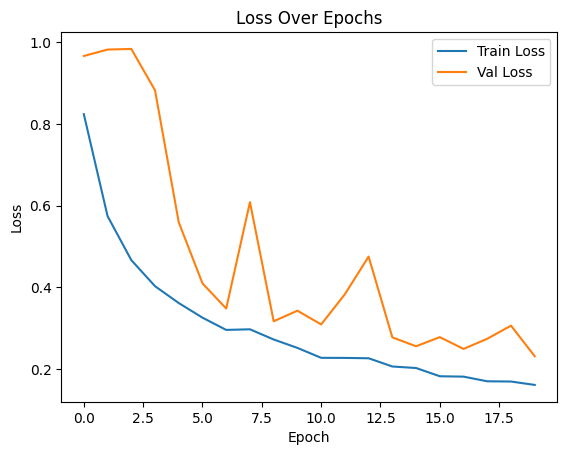

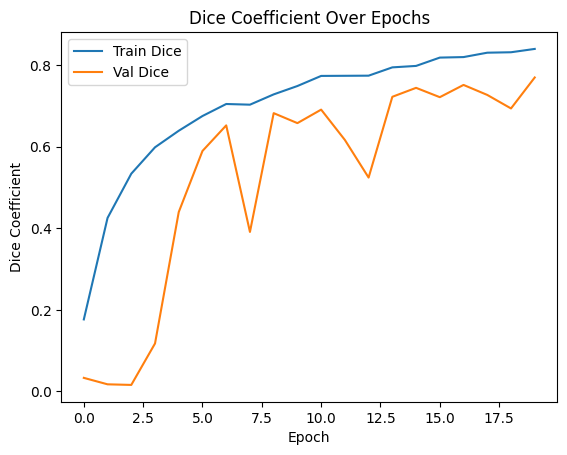

In [20]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Dice
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/tmp/ipython-input-23-2576427778.py:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-23-2576427778.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


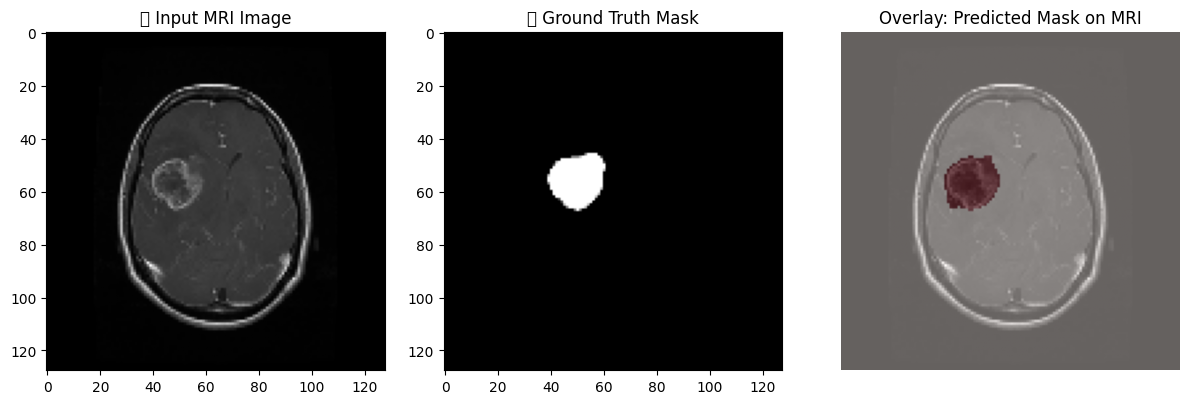

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


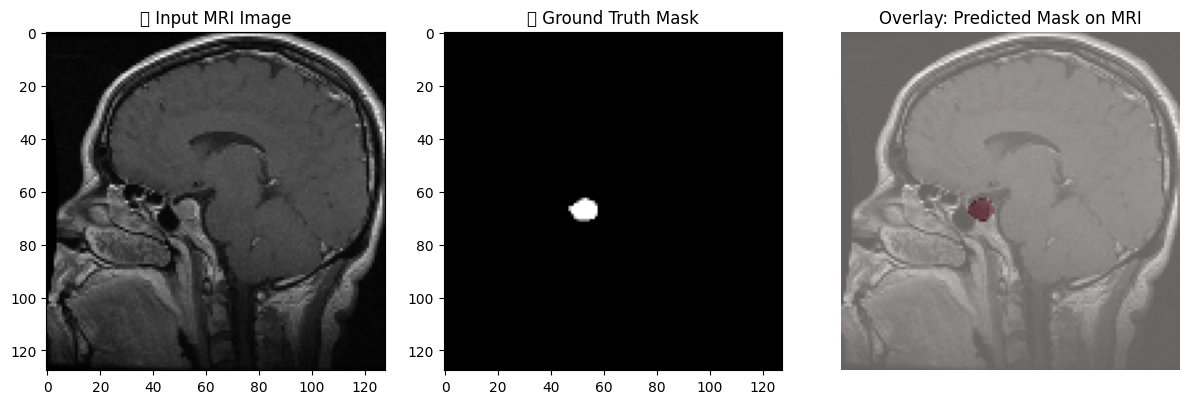

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


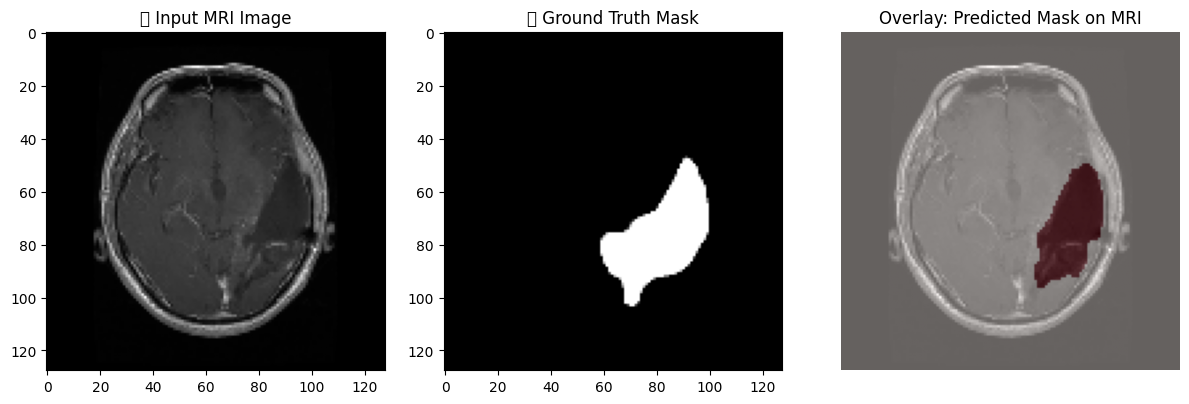

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


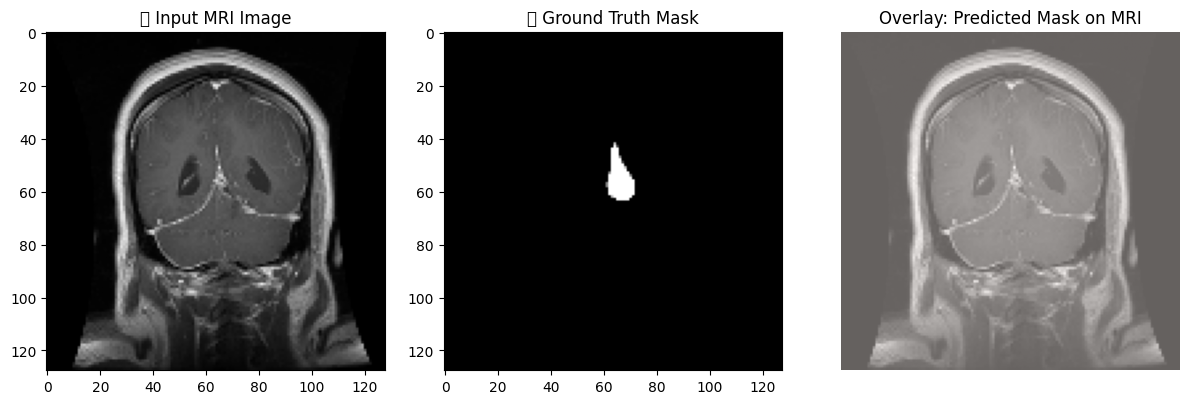

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


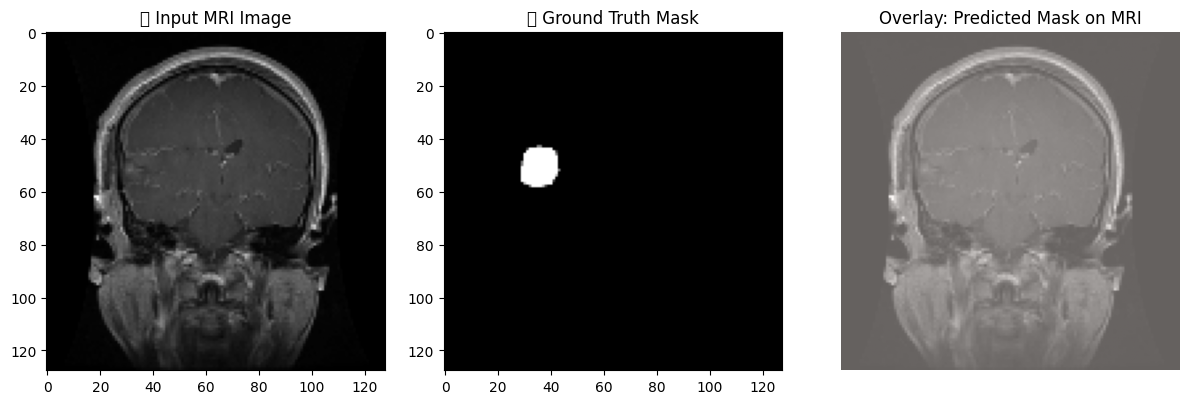

In [23]:
import matplotlib.pyplot as plt

# Number of test images to visualize
num_samples = 5

for i in range(num_samples):
    input_img = x_val[i]
    true_mask = y_val[i]

    # Predict
    pred_mask = model.predict(input_img[np.newaxis, ...])[0]

    # Threshold the prediction to get binary mask
    pred_mask_binary = (pred_mask > 0.5).astype('float32')

    # Plot
    plt.figure(figsize=(12, 4))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_img.squeeze(), cmap='gray')
    plt.title("🧠 Input MRI Image")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("✅ Ground Truth Mask")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
    plt.title("🔮 Predicted Mask")


    plt.imshow(input_img.squeeze(), cmap='gray')
    plt.imshow(pred_mask_binary.squeeze(), cmap='Reds', alpha=0.4)
    plt.title("Overlay: Predicted Mask on MRI")
    plt.axis('off')

    plt.tight_layout()
    plt.show()




In [24]:
model.save("best_unet_model.h5")